In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
from keras.utils import np_utils
from tqdm import tqdm_notebook as tqdm


In [2]:
label_df = pd.read_csv('data/formated_label_other.csv')
data_df = pd.read_csv('data/formated_data.csv')
use_df = pd.read_csv('data/use_data.csv')

In [3]:
def forward_exact_df_fun(X_df , time_list ,label_second , minus):
    df_exact = X_df[((X_df['hour'] )== int(time_list[0])) 
                    & (label_second - minus <= X_df['minute'] *60 + X_df['second']) 
                    & (X_df['minute'] *60 + X_df['second'] <=label_second)]
    return df_exact

def back_exact_df_fun(X_df , time_list ,label_second , minus):
    df_exact = X_df[((X_df['hour'] )== int(time_list[0])) 
                    & (label_second  <= X_df['minute'] *60 + X_df['second']) 
                    & (X_df['minute'] *60 + X_df['second'] <=label_second  + minus )]
    return df_exact

def check_lenght(df_exact , X_df, time_list, label_second,minus,mode):
    if df_exact.shape[0] == 0:
            minute = 2
            if mode == 'forward':
                while df_exact.shape[0] < (minus+1)*15:
                    df_exact = forward_exact_df_fun(X_df, time_list , label_second, minute)
                    minute += 1
            elif mode == 'back':
                 while df_exact.shape[0] < (minus+1)*15:
                    df_exact = back_exact_df_fun(X_df, time_list , label_second, minute)
                    minute += 1   
                
    while df_exact.shape[0] < (minus+1)*15 :
        last_index = df_exact.shape[0]
        df_exact = df_exact.append(df_exact[last_index-1:last_index]).reset_index(drop=True)
        
    if df_exact.shape[0] > (minus+1)*15:
        df_exact = df_exact.iloc[0:(minus+1)*15]
    return df_exact

def formatted(df_exact):
        df_exact = df_exact.drop("path", axis=1)
        df_exact = df_exact.drop("hour", axis=1)
        df_exact = df_exact.drop("minute", axis=1)
        df_exact = df_exact.drop("second", axis=1)
        
        arm = df_exact['arm'].str.replace('[', ' ').str.replace(']','')
        head = df_exact['head'].str.replace('[', ' ').str.replace(']','')
        body = df_exact['body'].str.replace('[', ' ').str.replace(']','')
        leg = df_exact['leg'].str.replace('[', ' ').str.replace(']','')
        
        arm = arm.str.split(',')
        head = head.str.split(',')
        body = body.str.split(',')
        leg = leg.str.split(',')
        
        return arm.reset_index(drop=True) , head.reset_index(drop=True) , body.reset_index(drop=True) , leg.reset_index(drop=True)
    
def get_chunk(arm, head , body , leg, mode):
    chunk = []
    if mode == 'forward':
        for order  in range(arm.shape[0]):
            try:
                pocision = np.array([int(arm[order][0]) , int(arm[order][1]),int(head[order][0]) ,
                                            int(head[order][1]),int(body[order][0]) , int(body[order][1]),
                                           int(leg[order][0]) , int(leg[order][1])])
                chunk.append(pocision)
            except :
                print('forward:エラー')
                print('エラーメッセージ:', sys.exc_info()[0])
                print('order : ' , order)
                
                break
    elif mode == 'back':
        for order in range(arm.size-1, -1 , -1):
            try :
                pocision = np.array([int(arm[order][0]) , int(arm[order][1]),int(head[order][0]) ,
                                    int(head[order][1]),int(body[order][0]) , int(body[order][1]),
                                   int(leg[order][0]) , int(leg[order][1])])
                chunk.append(pocision)
            except:
                print('back : エラー')
                print(order , arm)
                print(head)
                break
                          
    return chunk
    
        
def _load_data(X_df,y_df ,minus):
    forward_X, back_X, Y = [] , [] , []
    for (index, row) , _ in zip(y_df.iterrows() , tqdm(range(y_df.shape[0]))):
        time_list = row[0].split(':')
        label_second = int(time_list[1])*60 + int(time_list[2])
        forward_exact = forward_exact_df_fun(X_df, time_list, label_second,minus)
        forward_exact = check_lenght(forward_exact, X_df, time_list , label_second,minus,'forward')
        back_exact = back_exact_df_fun(X_df, time_list, label_second,minus)
        back_exact = check_lenght(back_exact, X_df, time_list , label_second,minus,'back')
            
        f_arm , f_head , f_body , f_leg = formatted(forward_exact)
        b_arm , b_head , b_body , b_leg = formatted(back_exact)
     
        f_chunk = get_chunk(f_arm , f_head , f_body , f_leg , 'forward')
        b_chunk = get_chunk(b_arm , b_head , b_body , b_leg,'back')

        forward_X.append(np.array(f_chunk))
        back_X.append(np.array(b_chunk))
        Y.append(row[1])

    return np.array(forward_X),  np.array(back_X) ,np.array(Y) 

#minus 何秒前までの動画を使うか
def train_test_split(X_df,Y_df, test_size ,minus):
    ntrn = round(len(Y_df) * (1-test_size))
    ntrn = int(ntrn)
    
    f_X_train,b_X_train , y_train = _load_data(X_df,Y_df.iloc[0:ntrn] ,minus)
    f_X_test , b_X_test ,  y_test   = _load_data(X_df, Y_df.iloc[ntrn:] ,minus)
    return (f_X_train,b_X_train , y_train), ( f_X_test , b_X_test ,  y_test )

In [4]:
(f_X_train,b_X_train , y_train) , ( f_X_test , b_X_test ,  y_test ) = train_test_split(data_df , label_df.sample(frac=1), 0.2 ,9)

In [5]:
Y_train = np_utils.to_categorical(y_train, 69)
Y_test = np_utils.to_categorical(y_test, 69)

In [ ]:
import Bilstm_model 
bilstm = Bilstm_model.BiLSTM()
model = bilstm.create_model(f_X_train,b_X_train,'categorical_crossentropy', 'adam' , 'accuracy')

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
LSTM_input (InputLayer)         [(None, 150, 8)]     0                                            
__________________________________________________________________________________________________
BiLSTM_input (InputLayer)       [(None, 150, 8)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 300)          370800      LSTM_input[0][0]                 
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 300)          370800      BiLSTM_input[0][0]               
______________________________________________________________________________________________

In [8]:
label_df.head()

,0,1,2
0,7:55:55,0,朝処理
1,7:55:56,0,朝処理
2,7:55:57,0,朝処理
3,7:55:58,0,朝処理
4,7:55:59,0,朝処理


In [8]:
history = model.fit([f_X_train , b_X_train], Y_train,batch_size=32, validation_split=0.1, epochs=300)

Train on 9153 samples, validate on 1018 samples
Epoch 1/300
9153/9153 [==============================] - 60s 7ms/sample - loss: 2.3928 - accuracy: 0.3476 - val_loss: 1.9989 - val_accuracy: 0.4194
Epoch 2/300
9153/9153 [==============================] - 58s 6ms/sample - loss: 1.8882 - accuracy: 0.4288 - val_loss: 1.7792 - val_accuracy: 0.4411
Epoch 3/300
9153/9153 [==============================] - 59s 6ms/sample - loss: 1.6754 - accuracy: 0.4713 - val_loss: 1.5839 - val_accuracy: 0.4921
Epoch 4/300
9153/9153 [==============================] - 59s 6ms/sample - loss: 1.5496 - accuracy: 0.5048 - val_loss: 1.5108 - val_accuracy: 0.5206
Epoch 5/300
9153/9153 [==============================] - 59s 6ms/sample - loss: 1.4470 - accuracy: 0.5284 - val_loss: 1.6075 - val_accuracy: 0.4617
Epoch 6/300
9153/9153 [==============================] - 59s 6ms/sample - loss: 1.3798 - accuracy: 0.5395 - val_loss: 1.4311 - val_accuracy: 0.5255
Epoch 7/300
9153/9153 [==============================] - 59s 6ms

Epoch 56/300
9153/9153 [==============================] - 59s 6ms/sample - loss: 0.6119 - accuracy: 0.7772 - val_loss: 0.7781 - val_accuracy: 0.7505
Epoch 57/300
9153/9153 [==============================] - 59s 6ms/sample - loss: 0.6151 - accuracy: 0.7773 - val_loss: 0.8397 - val_accuracy: 0.7063
Epoch 58/300
9153/9153 [==============================] - 59s 6ms/sample - loss: 0.5963 - accuracy: 0.7792 - val_loss: 0.8485 - val_accuracy: 0.7279
Epoch 59/300
9153/9153 [==============================] - 59s 6ms/sample - loss: 0.6195 - accuracy: 0.7783 - val_loss: 0.8306 - val_accuracy: 0.7269
Epoch 60/300
9153/9153 [==============================] - 59s 6ms/sample - loss: 0.5967 - accuracy: 0.7870 - val_loss: 0.8737 - val_accuracy: 0.6837
Epoch 61/300
9153/9153 [==============================] - 59s 6ms/sample - loss: 0.6264 - accuracy: 0.7720 - val_loss: 0.8491 - val_accuracy: 0.7171
Epoch 62/300
9153/9153 [==============================] - 59s 6ms/sample - loss: 0.5425 - accuracy: 0.8042

Epoch 111/300
9153/9153 [==============================] - 58s 6ms/sample - loss: 0.5409 - accuracy: 0.8019 - val_loss: 0.6441 - val_accuracy: 0.8104
Epoch 112/300
9153/9153 [==============================] - 59s 6ms/sample - loss: 0.4454 - accuracy: 0.8368 - val_loss: 0.6606 - val_accuracy: 0.7976
Epoch 113/300
9153/9153 [==============================] - 59s 6ms/sample - loss: 0.4314 - accuracy: 0.8408 - val_loss: 0.7052 - val_accuracy: 0.7692
Epoch 114/300
9153/9153 [==============================] - 59s 6ms/sample - loss: 0.4460 - accuracy: 0.8336 - val_loss: 0.6910 - val_accuracy: 0.7800
Epoch 115/300
9153/9153 [==============================] - 59s 6ms/sample - loss: 0.4009 - accuracy: 0.8489 - val_loss: 0.6758 - val_accuracy: 0.7780
Epoch 116/300
9153/9153 [==============================] - 59s 6ms/sample - loss: 0.4588 - accuracy: 0.8369 - val_loss: 0.6687 - val_accuracy: 0.7868
Epoch 117/300
9153/9153 [==============================] - 59s 6ms/sample - loss: 0.4110 - accuracy:

9153/9153 [==============================] - 59s 6ms/sample - loss: 0.3742 - accuracy: 0.8599 - val_loss: 0.7434 - val_accuracy: 0.7721
Epoch 166/300
9153/9153 [==============================] - 59s 6ms/sample - loss: 0.3267 - accuracy: 0.8806 - val_loss: 0.7089 - val_accuracy: 0.8035
Epoch 167/300
9153/9153 [==============================] - 59s 6ms/sample - loss: 0.4993 - accuracy: 0.8194 - val_loss: 0.8415 - val_accuracy: 0.7505
Epoch 168/300
9153/9153 [==============================] - 59s 6ms/sample - loss: 0.4141 - accuracy: 0.8435 - val_loss: 0.7049 - val_accuracy: 0.7947
Epoch 169/300
9153/9153 [==============================] - 59s 6ms/sample - loss: 0.3681 - accuracy: 0.8638 - val_loss: 0.7111 - val_accuracy: 0.7839
Epoch 170/300
9153/9153 [==============================] - 58s 6ms/sample - loss: 0.3812 - accuracy: 0.8582 - val_loss: 0.6480 - val_accuracy: 0.8124
Epoch 171/300
9153/9153 [==============================] - 59s 6ms/sample - loss: 0.3639 - accuracy: 0.8632 - val_

Epoch 220/300
9153/9153 [==============================] - 59s 6ms/sample - loss: 0.2941 - accuracy: 0.8907 - val_loss: 0.6951 - val_accuracy: 0.8134
Epoch 221/300
9153/9153 [==============================] - 59s 6ms/sample - loss: 0.2767 - accuracy: 0.8977 - val_loss: 0.7132 - val_accuracy: 0.8183
Epoch 222/300
9153/9153 [==============================] - 59s 6ms/sample - loss: 0.3066 - accuracy: 0.8870 - val_loss: 0.7876 - val_accuracy: 0.8006
Epoch 223/300
9153/9153 [==============================] - 59s 6ms/sample - loss: 0.2892 - accuracy: 0.8959 - val_loss: 0.7022 - val_accuracy: 0.8016
Epoch 224/300
9153/9153 [==============================] - 59s 6ms/sample - loss: 0.3048 - accuracy: 0.8959 - val_loss: 0.7069 - val_accuracy: 0.8271
Epoch 225/300
9153/9153 [==============================] - 59s 6ms/sample - loss: 0.3656 - accuracy: 0.8752 - val_loss: 0.7383 - val_accuracy: 0.8153
Epoch 226/300
9153/9153 [==============================] - 59s 6ms/sample - loss: 0.3099 - accuracy:

9153/9153 [==============================] - 59s 6ms/sample - loss: 0.2435 - accuracy: 0.9084 - val_loss: 0.7012 - val_accuracy: 0.8242
Epoch 275/300
9153/9153 [==============================] - 59s 6ms/sample - loss: 0.2161 - accuracy: 0.9216 - val_loss: 0.8014 - val_accuracy: 0.8124
Epoch 276/300
9153/9153 [==============================] - 59s 6ms/sample - loss: 0.2718 - accuracy: 0.9029 - val_loss: 0.7370 - val_accuracy: 0.8301
Epoch 277/300
9153/9153 [==============================] - 59s 6ms/sample - loss: 0.2683 - accuracy: 0.9044 - val_loss: 0.6966 - val_accuracy: 0.8350
Epoch 278/300
9153/9153 [==============================] - 59s 6ms/sample - loss: 0.2380 - accuracy: 0.9141 - val_loss: 0.7360 - val_accuracy: 0.8261
Epoch 279/300
9153/9153 [==============================] - 59s 6ms/sample - loss: 0.2220 - accuracy: 0.9223 - val_loss: 0.7966 - val_accuracy: 0.8045
Epoch 280/300
9153/9153 [==============================] - 59s 6ms/sample - loss: 0.2588 - accuracy: 0.9064 - val_

In [9]:
model.save_weights('model/otherLabel_bilstm10sec_epoch300.h5')

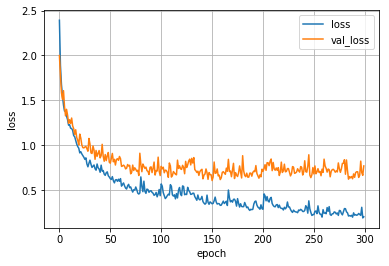

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']

nb_epoch = len(loss)
plt.figure()
plt.plot(range(nb_epoch),loss , label = 'loss')
plt.plot(range(nb_epoch), val_loss, label = 'val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

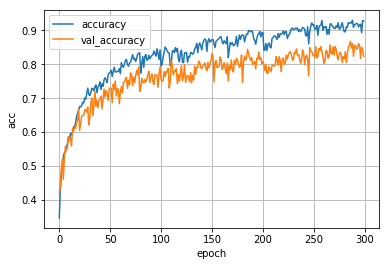

In [11]:
loss = history.history['accuracy']
val_loss = history.history['val_accuracy']

nb_epoch = len(loss)
plt.figure()
plt.plot(range(nb_epoch),loss , label = 'accuracy')
plt.plot(range(nb_epoch), val_loss, label = 'val_accuracy')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

In [13]:
model.load_weights('model/bilstm5sec_epoch500.h5')
(f_all,b_all , y_all) , ( _ , _ ,  _ ) = train_test_split(data_df , label_df, 0 ,4)
result = model.predict([f_all, b_all])

In [100]:
label_df = pd.read_csv('data/formated_label.csv',header=None)
result_df = label_df
for index, row in enumerate(result):
    result_df.loc[index ,2] = row.argmax()

In [106]:
label_id = pd.read_csv('data/label_id.csv').values

In [116]:
for index , row in result_df.iterrows():
    ans = label_id[label_id == int(row[1])][0]
    re = label_id[label_id == int(row[2])][0]
    try:
        result_df.loc[index , 1] = label_id[ans][0]
        result_df.loc[index , 2] = label_id[re][0]
    except:
        print('エラーメッセージ:', sys.exc_info()[0])
        break

## 予測と結果の出力

In [12]:
predict_df = pd.read_csv('data/0904formated_data.csv')

In [13]:
(f_predict,b_predict , y_train) , ( _ , _ ,  _ ) = train_test_split(predict_df , label_df.sample(frac=1), 0 ,9)

In [41]:
import Bilstm_model 
bilstm = Bilstm_model.BiLSTM()
model = bilstm.create_model(f_predict,b_predict,'categorical_crossentropy', 'adam' , 'accuracy')
model.load_weights('model/bilstm5sec_epoch500.h5')
result = model.predict([f_predict, b_predict])

In [14]:
result = model.predict([f_predict, b_predict])

In [15]:
predict_df = pd.read_csv('data/formated_label_other.csv')
label_id = pd.read_csv('data/label_id.csv').values
result_df =predict_df
for index, row in enumerate(result):
    ans = label_id[label_id == row.argmax()][0]
    result_df.loc[index,2] = label_id[ans][0]

In [16]:
predict_df.head()

,0,1,2,2
0,7:55:55,0,朝処理,エリア準備
1,7:55:56,0,朝処理,その他
2,7:55:57,0,朝処理,版取り外し
3,7:55:58,0,朝処理,パスライン清掃
4,7:55:59,0,朝処理,最終確認


In [17]:
result_df.to_csv('data/0904_other_predict.csv', index=False)